**Name:** SIVAKUMAR Srinivas

**EID:** ssivakuma2

**Kaggle Team Name:** Srinivas Sivakumar

# CS4487 - Assignment 2 - Sound Effects Retrieval
Due date: November 5, 2018, 11:59pm

## Goal
In this assignment, the task is to use a query sound to retrieve the top 10 similar sounds from the training set.  This kind of content-based retrieval system could be useful to musicians and sound engineers who want to find similar sounds in a sound library.


## Methodology
Retrieval is based on finding the documents in the training set that are closest to the query document.  The important thing is how to define the _feature space_ for representing the documents (in this case, audio), and the _distance_ to determine which documents are close.
You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space and distance measure between documents.  You are free to use methods that were not introduced in class.  A validation set with a list of ground-truth relevant documents is provided to help development of your method.

## Evaluation of Retrieval

For evaluation, you will predict the top-10 similar training documents for each query.  The evaluation metric is "Mean Average Precision" (MAP@10).  Here is how it is calculated.  For each query, we go through the list of retrieved documents in order from 1st to 10th. When the i-th document is relevant, we calculate the "Precision@i" as "Number relevant documents in top-i" / i.  If the i-th document is not relevant, then the Precision@i is 0.   The "average precision" (AP) is the average of the Precision@i values for i=1..10.
The MAP is the mean AP over all the queries.  Higher values are better.
More information can be found [here](https://www.kaggle.com/wiki/MeanAveragePrecision).


## Evaluation on Kaggle

You need to submit your test retrievals to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!


## What to hand in
You need to turn in the following things:

1. This ipynb file `Assignment2-2018.ipynb` with your source code and documentation.  _**You should write about all the various attempts that you make to find a good solution.**_
2. Your final submission file to Kaggle.
3. The ipynb file `Assignment2-2018-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**

Files should be uploaded to Assignment 2 on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 40% - Results using various feature representations, dimensionality reduction methods, etc.
- 20% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 20% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

<hr>

In [25]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display

In [26]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training, validation, and test data are stored in various pickle files.
The below code will load the data.

In [27]:
train_tags = load_pickle('sounds-data/train_tags.pickle3')
train_mfccs = load_pickle('sounds-data/train_mfccs.pickle3')
train_info = load_pickle('sounds-data/train_info.pickle3')

valid_mfccs = load_pickle('sounds-data/val_mfccs.pickle3')
valid_info = load_pickle('sounds-data/val_info.pickle3')
valid_matches = load_pickle('sounds-data/val_matches.pickle3')

test_mfccs = load_pickle('sounds-data/test_mfccs.pickle3')
test_info = load_pickle('sounds-data/test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set (contains a link to the sound).
- `train_mfccs` - the MFCC features for each sound in the training set.  MFCCs are [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a type of spectral feature vector for audio.
- `train_tags` - the descriptive tags for each sound in the training set. Tags have already been stemmed.
- `valid_info` - info about each sound in the validation set.
- `valid_mfccs` - the MFCC features for each sound in the validation set.
- `valid_matches` - the indicies of matches (to the training set) for each sound in the validation set.
- `test_info` - info about each sound in the test set.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the first sound in the training set, as well as the tags.

In [28]:
showAudio(train_info[0])
print(train_tags[0])
print(len(train_info))

ring metal
2492


and here are the MFCCs for the first sound in the training set.  The MFCC vectors are 13-dimensions each, and they are extracted using a sliding window over the sound.

(345, 13)


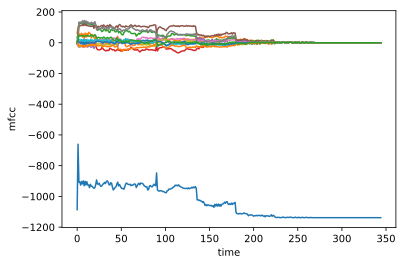

In [29]:
print(train_mfccs[0].shape)
plt.plot(train_mfccs[0]);
plt.xlabel('time')
plt.ylabel('mfcc');

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [30]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [31]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)
valid_dmfccs = compute_delta_mfccs(valid_mfccs)

In [32]:
print(train_dmfccs[0][0])

[-1.08599561e+03  6.16124954e+01  3.26212196e+01  4.88774490e+00
 -9.12226868e+00 -8.47605133e+00 -7.11513519e-01  4.72403717e+00
  3.38615799e+00 -1.22250366e+00 -2.96123886e+00 -7.83477783e-01
  1.45116425e+00  4.25331665e+02  4.10426712e+01  2.63916092e+01
  2.21846256e+01  1.22690163e+01  5.83558960e+01 -2.38054867e+01
  3.96332779e+01 -1.63995991e+01  1.71343832e+01  1.39941864e+01
 -2.17901421e+00  1.58920860e+01]


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [33]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(600481, 26)


In [42]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::10])  # subsample by 10 to make it faster
km.cluster_centers_

KeyboardInterrupt: 

Now transform the data into BOW.

In [11]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [25]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)
valid_bow = bow_transform(km, valid_dmfccs)


## Baseline experiments

Next, we will run a baseline experiment doing retrieval with bag-of-audio words.

Here are some useful functions for nearest neighbor retrieval, computing MAP@10 for evaluation, and saving the Kaggle submission file.

In [13]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Euclidean distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='euclidean')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [14]:
def calc_MAP(Ytrue, Ypred, K=10):
    # calculate the mean average precision
    # returns the MAP for the whole set, and the AP for each document
    
    AP = zeros(len(Ytrue))
    # for each document
    for j in range(len(Ytrue)):
        Yt = Ytrue[j]
        if not isinstance(Yt, ndarray):
            Yt = array([Yt])
        Yp = Ypred[j]
        # calculate average precision @ K
        nummatches = 0.
        score = 0.
        for i,y in enumerate(Yp[0:K]):
            # if match at this level, calculate P
            if any(y==Yt):
                nummatches += 1.
                P = nummatches / (i+1)
                score += P
        AP[j] = score / K #min(K, len(Yt))

    # mean over all documents
    MAP = mean(AP)
    return (MAP, AP)

# write a kaggle submission file for retrieval
def write_csv_kaggle_retr_sub(fname, Yretr):
    # header
    tmp = [['Id', 'RetrievedDocuments']]
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yretr)):
        y = Yretr[i]
        ystr = [str(q) for q in y]
        tmp2 = [str(i+1)]
        tmp2.append(" ".join(ystr))        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

Next, apply TF-IDF to the count vectors.

In [15]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
valid_Xtf = tf_trans.transform(valid_bow)

Now do the retrieval on the validation set and test set.

In [16]:
# do retrieval
test_retr = nn_retr(test_Xtf, train_Xtf)
val_retr  = nn_retr(valid_Xtf, train_Xtf)

We can evaluate on the validation set using the provided matches. The plot shows the histogram of Average precision (AP@10) for the query sounds in the validation set, as well as the overall MAP.

0.11026467868700877


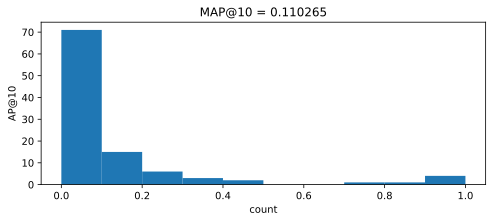

In [17]:
# evaluate on the validation set with P@10
vMAP,vAP = calc_MAP(valid_matches, val_retr)

print(vMAP)
plt.figure(figsize=(8,3))
plt.hist(vAP)
plt.title('MAP@10 = %g' % (vMAP,))
plt.xlabel('count')
plt.ylabel('AP@10');

Now write the retrieval results for the test set for submission to Kaggle.

In [18]:
write_csv_kaggle_retr_sub("sounds_test_kaggle_bow_baseline.csv", test_retr)

In this baseline method we didn't use the tags that come with the training set.  The retrieval is completely unsupervised, and we are hoping that our feature space is perfectly good for retrieval.

One idea is to build another feature space based on the tags, which we call a "semantic space".  First, build classifiers for each tag (tag or not-tag). Then for each song, use the tag predictions (or tag probabilites) as the new feature vector.

## YOUR CODE and DOCUMENTATION HERE

In [24]:
#Having a look at the tags
for i in range(10):
    print(i,train_info[i])

0 {'tags': ['metallic', 'ringing'], 'id': 552, 'previews': {'preview-hq-ogg': 'http://www.freesound.org/data/previews/0/552_291-hq.ogg', 'preview-lq-mp3': 'http://www.freesound.org/data/previews/0/552_291-lq.mp3', 'preview-hq-mp3': 'http://www.freesound.org/data/previews/0/552_291-hq.mp3', 'preview-lq-ogg': 'http://www.freesound.org/data/previews/0/552_291-lq.ogg'}, 'analysis_frames': 'http://www.freesound.org/data/analysis/0/552_291_frames.json'}
1 {'tags': ['emotive', 'juicy', 'synth'], 'id': 714, 'previews': {'preview-hq-ogg': 'http://www.freesound.org/data/previews/0/714_19-hq.ogg', 'preview-lq-mp3': 'http://www.freesound.org/data/previews/0/714_19-lq.mp3', 'preview-hq-mp3': 'http://www.freesound.org/data/previews/0/714_19-hq.mp3', 'preview-lq-ogg': 'http://www.freesound.org/data/previews/0/714_19-lq.ogg'}, 'analysis_frames': 'http://www.freesound.org/data/analysis/0/714_19_frames.json'}
2 {'tags': ['bajo', 'pad'], 'id': 937, 'previews': {'preview-hq-ogg': 'http://www.freesound.org

Dimensionality can be reduced as each dimension represents a feature and there are 26 dimensions for the DMFCCs and 13 for the MFCCs represented by TF-IDF.


In [31]:
def pcaReduction(features,components):
    pca = decomposition.PCA(n_components=components)
    result = pca.fit_transform(features)
    return (pca,result)

In [52]:
#Running Kmeans
best_pca = decomposition.PCA(n_components=5)
best_acc = 0
best_components = 5
for i in range(5,15):
    all_dmfccs = vstack(train_dmfccs)
    
    pca,new_all_dmfccs = pcaReduction(all_dmfccs,i)
    new_train_dmfccs = []

    for j in range(len(train_dmfccs)):
        new_train_dmfccs.append(pca.transform(train_dmfccs[j]))
        
    new_valid_dmfccs = []
    for j in range(len(valid_dmfccs)):
        new_valid_dmfccs.append(pca.transform(valid_dmfccs[j]))
        
    km = cluster.KMeans(n_clusters=100, random_state=4487)
    km.fit(new_all_dmfccs[0::10])
    train_bow = bow_transform(km, new_train_dmfccs)
    valid_bow = bow_transform(km, new_valid_dmfccs)
    
    train_Xtf = tf_trans.fit_transform(train_bow)
    valid_Xtf = tf_trans.transform(valid_bow)
    
    val_retr  = nn_retr(valid_Xtf, train_Xtf)
    vMAP,vAP = calc_MAP(valid_matches, val_retr)
    
    print("MAP =",vMAP,"for components =",i)
    if vMAP > best_acc:
        best_pca = pca
        best_acc = vMAP
        best_components = i
        

MAP = 0.10992756973339499 for components = 5
MAP = 0.09320080135614114 for components = 6
MAP = 0.09715634150100169 for components = 7
MAP = 0.11072969640930805 for components = 8
MAP = 0.10195253505933118 for components = 9
MAP = 0.10809215595623363 for components = 10
MAP = 0.10529819694868238 for components = 11
MAP = 0.10101286793034364 for components = 12
MAP = 0.1032516566497149 for components = 13
MAP = 0.10560718138388041 for components = 14


In [54]:
print("Number of Components =",best_components,"with accuracy =",best_acc)

Number of Components = 8 with accuracy = 0.11072969640930805


Subsampling makes the computation faster but the drawback is that we are not using the entire training set. The strategy I will be using is to find the best hyperparameters by using subsampling then using the entire dataset for one final computation. #Edit: Don't have time to use entire dataset

Trying out different classifiers.

In [36]:
def bow_transform(model, mfccs):
    numwords = model.means_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [11]:
pca,new_all_dmfccs = pcaReduction(all_dmfccs,best_components)
new_train_dmfccs = []
for j in range(len(train_dmfccs)):
    new_train_dmfccs.append(pca.transform(train_dmfccs[j]))
        
new_valid_dmfccs = []
for j in range(len(valid_dmfccs)):
    new_valid_dmfccs.append(pca.transform(valid_dmfccs[j]))
    
gmm_full = mixture.GaussianMixture(n_components=500, covariance_type='full',
                               random_state=4487, verbose=2)
gmm_full.fit(new_all_dmfccs[0::10])


NameError: name 'pcaReduction' is not defined

In [76]:
train_bow = bow_transform(gmm_full, new_train_dmfccs)
valid_bow = bow_transform(gmm_full, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("MAP =",vMAP)

MAP = 0.09792880258899678


In [78]:
gmm_diag = mixture.GaussianMixture(n_components=500, covariance_type='diag',
                               random_state=4487, verbose=2)
gmm_diag.fit(new_all_dmfccs[0::10])

train_bow = bow_transform(gmm_diag, new_train_dmfccs)
valid_bow = bow_transform(gmm_diag, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("MAP =",vMAP)

Initialization 0
  Iteration 0	 time lapse 61.97639s	 ll change inf
  Iteration 10	 time lapse 39.94460s	 ll change 0.01625
  Iteration 20	 time lapse 40.69532s	 ll change 0.00726
  Iteration 30	 time lapse 41.31373s	 ll change 0.00408
  Iteration 40	 time lapse 41.06056s	 ll change 0.00166
  Iteration 50	 time lapse 41.44614s	 ll change 0.00120
Initialization converged: True	 time lapse 274.72766s	 ll -35.61771
MAP = 0.10288488210818308


In [80]:
gmm_sphere = mixture.GaussianMixture(n_components=100, covariance_type='spherical',
                               random_state=4487, verbose=2)
gmm_sphere.fit(new_all_dmfccs[0::10])

train_bow = bow_transform(gmm_sphere, new_train_dmfccs)
valid_bow = bow_transform(gmm_sphere, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("MAP =",vMAP)

Initialization 0
  Iteration 0	 time lapse 15.12280s	 ll change inf
  Iteration 10	 time lapse 9.50289s	 ll change 0.47248
  Iteration 20	 time lapse 9.42929s	 ll change 0.00192
  Iteration 30	 time lapse 9.54011s	 ll change 0.00517
  Iteration 40	 time lapse 9.51437s	 ll change 0.00209
  Iteration 50	 time lapse 9.50335s	 ll change 0.00106
Initialization converged: True	 time lapse 63.56097s	 ll -37.35142
MAP = 0.10410194174757281


In [81]:
dpgmm = mixture.BayesianGaussianMixture(covariance_type='full', 
                   weight_concentration_prior=1, 
                   n_components=500, max_iter=100, random_state=4487, verbose=2 )

dpgmm.fit(new_all_dmfccs[0::10])

train_bow = bow_transform(dpgmm, new_train_dmfccs)
valid_bow = bow_transform(dpgmm, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("MAP =",vMAP)

Initialization 0
  Iteration 0	 time lapse 83.73847s	 ll change inf
  Iteration 10	 time lapse 224.08097s	 ll change 1421.51419
  Iteration 20	 time lapse 208.36748s	 ll change 451.54632
  Iteration 30	 time lapse 218.81750s	 ll change 251.42365
  Iteration 40	 time lapse 229.00125s	 ll change 129.48617
  Iteration 50	 time lapse 242.68205s	 ll change 68.10805
  Iteration 60	 time lapse 233.45399s	 ll change 44.65309
  Iteration 70	 time lapse 241.86835s	 ll change 27.12858
  Iteration 80	 time lapse 230.62927s	 ll change 26.86447
  Iteration 90	 time lapse 215.62995s	 ll change 13.94482
Initialization converged: False	 time lapse 2307.68646s	 ll -1932643.58104


/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


MAP = 0.09511750654954539


# Different Distance Formulae

# Cosine

In [82]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Cosine distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='cosine')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [84]:
train_bow = bow_transform(gmm_full, new_train_dmfccs)
valid_bow = bow_transform(gmm_full, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using full covariance and cosine distance, MAP =",vMAP)

train_bow = bow_transform(gmm_sphere, new_train_dmfccs)
valid_bow = bow_transform(gmm_sphere, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using spherical covariance and cosine distance, MAP =",vMAP)

train_bow = bow_transform(gmm_diag, new_train_dmfccs)
valid_bow = bow_transform(gmm_diag, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using diagonal covariance and cosine distance, MAP =",vMAP)

train_bow = bow_transform(dpgmm, new_train_dmfccs)
valid_bow = bow_transform(dpgmm, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("DPGMM using cosine distance, MAP =",vMAP)

GMM using full covariance and cosine distance, MAP = 0.09857990445369084
GMM using spherical covariance and cosine distance, MAP = 0.10068654646324551
GMM using diagonal covariance and cosine distance, MAP = 0.11984627831715211
DPGMM using cosine distance, MAP = 0.1167333179226383


The Cosine difference measures the similarity of vectors with respect to the origin, while the euclidean measures the distance between particular points of interest along the vector. In this data set it doesn't matter much as to which metric we implement as both yeild the similar result. (feature dependent problem).

# Manhattan Distance

In [35]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Manhattan distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='cityblock')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [87]:
train_bow = bow_transform(gmm_full, new_train_dmfccs)
valid_bow = bow_transform(gmm_full, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using full covariance and Manhattan distance, MAP =",vMAP)

train_bow = bow_transform(gmm_sphere, new_train_dmfccs)
valid_bow = bow_transform(gmm_sphere, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using spherical covariance and Manhattan distance, MAP =",vMAP)

train_bow = bow_transform(gmm_diag, new_train_dmfccs)
valid_bow = bow_transform(gmm_diag, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using diagonal covariance and Manhattan distance, MAP =",vMAP)

train_bow = bow_transform(dpgmm, new_train_dmfccs)
valid_bow = bow_transform(dpgmm, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("DPGMM using Manhattan distance, MAP =",vMAP)

GMM using full covariance and Manhattan distance, MAP = 0.13789027585144092
GMM using spherical covariance and Manhattan distance, MAP = 0.13507666820773617
GMM using diagonal covariance and Manhattan distance, MAP = 0.15099630143319465
DPGMM using Manhattan distance, MAP = 0.1463607643704731


Manhattan distance is equal to the sum of the distances along each dimension. In 2-d, the manhattan distance between two points = (x2-x1) + (y2-y1). In this scenario, the manhattan distance provides a better result. The primary difference between this and the euclidean distance is that, no one dimension is given a large importance, due to the absence of squared terms.

In [94]:
new_test_dmfccs=[]
for j in range(len(test_dmfccs)):
        new_test_dmfccs.append(pca.transform(test_dmfccs[j]))

train_bow = bow_transform(gmm_diag, new_train_dmfccs)
valid_bow = bow_transform(gmm_diag, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)
test_bow = bow_transform(gmm_diag, new_test_dmfccs)
test_Xtf = tf_trans.transform(test_bow)

test_retr = nn_retr(test_Xtf, train_Xtf)
write_csv_kaggle_retr_sub("submission1.csv", test_retr)

# L1 Distance

In [97]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using Euclidean distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='l1')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [98]:
train_bow = bow_transform(gmm_full, new_train_dmfccs)
valid_bow = bow_transform(gmm_full, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using full covariance and L1 distance, MAP =",vMAP)

train_bow = bow_transform(gmm_sphere, new_train_dmfccs)
valid_bow = bow_transform(gmm_sphere, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using spherical covariance and L1 distance, MAP =",vMAP)

train_bow = bow_transform(gmm_diag, new_train_dmfccs)
valid_bow = bow_transform(gmm_diag, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using diagonal covariance and L1 distance, MAP =",vMAP)

train_bow = bow_transform(dpgmm, new_train_dmfccs)
valid_bow = bow_transform(dpgmm, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("DPGMM using L1 distance, MAP =",vMAP)

GMM using full covariance and L1 distance, MAP = 0.13789027585144092
GMM using spherical covariance and L1 distance, MAP = 0.13507666820773617
GMM using diagonal covariance and L1 distance, MAP = 0.15099630143319465
DPGMM using L1 distance, MAP = 0.1463607643704731


L1 norm is basically the absolute value of each vector. This is equivalent to the manhattan distance when one of the points is (0,0). Hence, we see similar results to Manhattan distance

# L2

In [99]:
def nn_retr(testX, trainX):
    # do retrieval using nearest neighbors
    # for each entry in testX, find the top 10 closest entries in trainX using L2 distance
    
    test_retr = []  # retrieval list

    # for each test document vector
    for tX in testX:
        # calculate the distance between tX and all training document vectors
        # (using Euclidean distance)
        if tX.ndim == 1:
            ttX = tX.reshape((1,tX.shape[0]))
        else:
            ttX = tX;
        D = metrics.pairwise_distances(ttX, trainX, metric='l2')
        Df = D.flatten()
        
        # find the 10 with smallest distance
        # (faster: bestmatches are the top-10, but not sorted yet)
        bestmatches_unsorted = argpartition(Df, 10)[0:10]
                
        # now sort bestmatches
        bestmatches_tmp = argsort(Df[bestmatches_unsorted])
        bestmatches = bestmatches_unsorted[bestmatches_tmp]        
        
        # slow, since it sorts everything
        #bestmatches = argsort(D.flatten())[0:10]
    
        # add to retrieval list
        test_retr.append(bestmatches)

    return test_retr

In [101]:
train_bow = bow_transform(gmm_full, new_train_dmfccs)
valid_bow = bow_transform(gmm_full, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using full covariance and L2 distance, MAP =",vMAP)

train_bow = bow_transform(gmm_sphere, new_train_dmfccs)
valid_bow = bow_transform(gmm_sphere, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using spherical covariance and L2 distance, MAP =",vMAP)

train_bow = bow_transform(gmm_diag, new_train_dmfccs)
valid_bow = bow_transform(gmm_diag, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("GMM using diagonal covariance and L2 distance, MAP =",vMAP)

train_bow = bow_transform(dpgmm, new_train_dmfccs)
valid_bow = bow_transform(dpgmm, new_valid_dmfccs)    
train_Xtf = tf_trans.fit_transform(train_bow)
valid_Xtf = tf_trans.transform(valid_bow)

val_retr  = nn_retr(valid_Xtf, train_Xtf)
vMAP,vAP = calc_MAP(valid_matches, val_retr)
print("DPGMM using L1 distance, MAP =",vMAP)

GMM using full covariance and L2 distance, MAP = 0.09792880258899678
GMM using spherical covariance and L2 distance, MAP = 0.10410194174757281
GMM using diagonal covariance and L2 distance, MAP = 0.10288488210818308
DPGMM using L1 distance, MAP = 0.09511750654954539


The L2 norm is also known as the Euclidean norm. This distance formula makes sure that there are strictly only positive vectors. Since, it is still just a variation of the euclidean distance we do not see any difference.

# Summary
- For this particular problem, manhattan distance along with Gaussian Mixture model with diagonal covariance matrix works the best.

Distance Formulas Explored
- Euclidean
- Manhattan
- Cosine
- CityBlock
- L1
- L2

Clustering Algorithms Explored
- K-Means
- GMM
- Diagonal Covariance
- Spherical Covariance
- DPGMM